In [61]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import ssmr_utils as ssmru
from visualization import papermode

papermode(plt, size=12)


In [62]:
abbrs = tuple(u.abbrange("M", 1, 8))
colors = u.COLORS
terrains = sorted(set(u.get_terrain(a) for a in abbrs))
terr_cols = {terr: colors[terr] for terr in terrains}
cols = {a: colors[u.get_terrain(a)] for a in abbrs}

rot_abbrs = ("M03", "M04", "M05", "M06")
lin_abbrs = ("M01", "M02", "M07")
mot_abbrs = (lin_abbrs, rot_abbrs)

dashes = {
    "rotational": "-",
    "linear": ":",
}

In [63]:
import collections
all_terrains = {abbr:u.get_terrain(abbr) for abbr in abbrs}
for k, v in all_terrains.items():
    print(f"{k} : {v}")
collections.Counter(all_terrains.values())

M01 : asphalt
M02 : asphalt
M03 : asphalt
M04 : asphalt
M05 : gravel
M06 : gravel
M07 : gravel


Counter({'asphalt': 4, 'gravel': 3})

In [64]:
colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}
terrains = sorted(set(u.get_terrain(a) for a in abbrs))

# Simple labels
splabs = u.COLORS


terr_cols = {terr: colors[terr] for terr in terrains}
def add_terrain_legend(
    mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure],
    highlighted: Optional[List[str]] = None,
    layout: str = "vertical",
):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    if layout.lower == "vertical":
        mpl_elem.legend(
            handles=legend_handles,
            bbox_to_anchor=(1, 0.5),
            loc="center left",
            title="Terrain",
        )
    else:
        mpl_elem.legend(
            handles=legend_handles,
            ncol=len(colors),
            bbox_to_anchor=(0.5, -0.03),
            loc="upper center",
            title="Terrain",
        )


def mod_abbr_to_name(mod_abbr: str) -> str:
    models_names = {
        "m2009": "Simplex\nOptimization",
        "p2014": "RLS",
        "p2022": "RLS w/ slope",
    }
    return models_names[mod_abbr]

In [65]:
figdir = u.get_figdir("thesis", subdir="modeling/preliminary-summary")

# Distributions

In [66]:
abbrs_dict = [{"abbr":a, "terrain":u.get_terrain(a)} for a in abbrs]
mu_df = pd.DataFrame(abbrs_dict)
model_values = u.model_subset_from_json(abbrs, pentzer2022.__MODEL_NAME__)
m2009_dfs = {abbr: morales2009.open_model_df(abbr) for abbr in abbrs}
p2014_dfs = {abbr: pentzer2014pow.open_model_df(abbr) for abbr in abbrs}
p2022_dfs = {abbr: pentzer2022.open_model_df(abbr) for abbr in abbrs}

In [67]:
def select(s: pd.Series):
    return s.dropna().iloc[-int(len(s.index) / 6) :].to_numpy()


mu_df["mu_m2009"] = mu_df.abbr.apply(lambda x: select(m2009_dfs[x].m_sym))
mu_df["mu_p2014"] = mu_df.abbr.apply(lambda x: select(p2014_dfs[x].m_sym))
mu_df["mu_p2022"] = mu_df.abbr.apply(lambda x: select(p2022_dfs[x].m_sym))
mu_df["G_m2009"] = mu_df.abbr.apply(lambda x: select(m2009_dfs[x].G_sym))
mu_df["G_p2014"] = mu_df.abbr.apply(lambda x: select(p2014_dfs[x].G_sym))
mu_df["G_p2022"] = mu_df.abbr.apply(lambda x: select(p2022_dfs[x].G_sym))

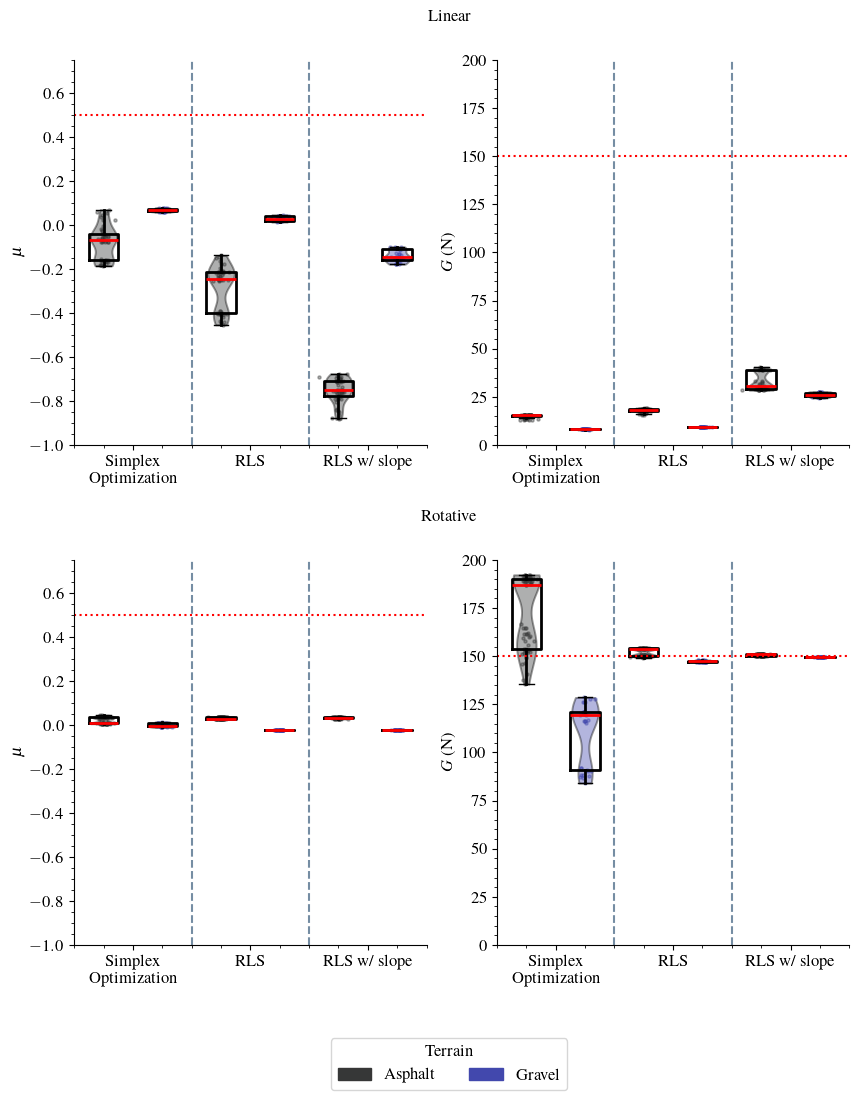

In [75]:
fig = plt.figure(figsize=(10, 10))
subfigs = fig.subfigures(nrows=2)

subfigs[0].suptitle("Linear")
subfigs[1].suptitle("Rotative")

violin_terrains = (*terrains, *terrains, *terrains)
x_ticks = [0.5, 2.5, 4.5]
xlabels = [mod_abbr_to_name(mod) for mod in ("m2009", "p2014", "p2022")]

for subfig, axs_abbrs in zip(subfigs, mot_abbrs):
    axs = subfig.subplots(ncols=2)

    m2009_data = [mu_df[(mu_df.terrain == terr) & mu_df.abbr.isin(axs_abbrs)] for terr in terrains]
    p2014_data = [mu_df[(mu_df.terrain == terr) & mu_df.abbr.isin(axs_abbrs)] for terr in terrains]
    p2022_data = [mu_df[(mu_df.terrain == terr) & mu_df.abbr.isin(axs_abbrs)] for terr in terrains]

    mu_data = [
        *[np.concatenate(dat.mu_m2009.values) for dat in m2009_data],
        *[np.concatenate(dat.mu_p2014.values) for dat in p2014_data],
        *[np.concatenate(dat.mu_p2022.values) for dat in p2022_data],
    ]
    G_data = [
        *[np.concatenate(dat.G_m2009.values) for dat in m2009_data],
        *[np.concatenate(dat.G_p2014.values) for dat in p2014_data],
        *[np.concatenate(dat.G_p2022.values) for dat in p2022_data],
    ]

    jitter = 0.04
    x_data = [np.array([i] * len(d)) for i, d in enumerate(mu_data)]
    x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
    x_pos = [*range(len(mu_data))]

    medianprops = dict(
        linewidth=2,
        color="r",
    )
    boxprops = dict(linewidth=2, color="k")
    violins_m = axs[0].violinplot(
        mu_data,
        positions=x_pos,
        widths=0.45,
        bw_method="silverman",
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )
    for pc, terr in zip(violins_m["bodies"], violin_terrains):
        pc.set_facecolor(colors[terr])
        pc.set_edgecolor("k")
        pc.set_linewidth(1.4)
        pc.set_alpha(0.4)
    axs[0].boxplot(
        mu_data,
        positions=x_pos,
        showfliers=False,
        showcaps=True,  # Do not show the caps
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops,
    )
    for x, y, terr in zip(x_jittered, mu_data, violin_terrains):
        axs[0].scatter(x, y, s=5, color=colors[terr], alpha=0.4)

    violins_G = axs[1].violinplot(
        G_data,
        positions=x_pos,
        widths=0.45,
        bw_method="silverman",
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )
    for pc, terr in zip(violins_G["bodies"], violin_terrains):
        pc.set_facecolor(colors[terr])
        pc.set_edgecolor("k")
        pc.set_linewidth(1.4)
        pc.set_alpha(0.4)
    axs[1].boxplot(
        G_data,
        positions=x_pos,
        showfliers=False,
        showcaps=True,  # Do not show the caps
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops,
    )
    for x, y, terr in zip(x_jittered, G_data, violin_terrains):
        axs[1].scatter(x, y, s=5, color=colors[terr], alpha=0.4)

    axs[0].set_ylabel("$\mu$")
    axs[1].set_ylabel("$G$ (N)")

    axs[0].plot([-0.5, 5.5], [0.5, 0.5], "r:")
    axs[1].plot([-0.5, 5.5], [150, 150], "r:")

    axs[0].set_ylim(-1, 0.75)
    axs[1].set_ylim(0, 200)

    for ax in axs:
        ax.spines[["right", "top"]].set_visible(False)
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        ax.axvline(x=1.5, color="xkcd:blue/grey", linestyle="--")
        ax.axvline(x=3.5, color="xkcd:blue/grey", linestyle="--")

        ax.set_xticks(x_ticks, xlabels)

        # ax.axvspan(-0.5, 1.5, color="xkcd:pale green", alpha=0.2)
        # ax.axvspan(1.5, 3.5, color="xkcd:ochre", alpha=0.2)
        # ax.axvspan(3.5, 5.5, color="xkcd:seafoam", alpha=0.2)

add_terrain_legend(fig)